# One-dimensional non-linear hydrostatic flow

Summary: there are four parts to this assignment
0. Calculating the non-linear, hydrostatic flow over an obstacle centred at 0 using the method of characteristics with Fr_0 = 0.8, 1.2
0. Repeating the same experiment using the MITgcm (using a reduced-gravity setup)
0. Evaluating the jump condition (its speed and dissipation)
0. More MITgcm simulations with various combinations of starting Froude number and obstacle height

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
from MyFunctions import central_diff_gradient
import matplotlib as mpl
from IPython.display import Image

interp_opts = dict(fill_value='extrapolate')
%matplotlib inline
mpl.rcParams['savefig.dpi'] = 80
warnings.filterwarnings('ignore','.*requires a non-empty pattern match*.') 

# Method of characteristics

Following Section 2.3 of Baines (1995), in particular Equations 2.3.4 and 2.3.5:
    
$$ \frac{\mathrm{d} }{\mathrm{d} t} \left(u \pm 2\sqrt{gd} \right) = -g \frac{\mathrm{d} h}{\mathrm{d} x} $$

on characteristic curves given by

$$ \frac{\mathrm{d} x}{\mathrm{d} t} = u \pm \sqrt{gd} $$


We want to solve this system of equations for a given bathymetry $h(x)$ and initial conditions given by

$$ u(x, t = 0) = u_0, \quad d(x, t = 0) = d_0 $$

where the initial velocity and depth are related by the initial Froude number

$$ u_0 = \mathrm{Fr}_0\sqrt{g d_0} $$

In [2]:
# Grid parameters
x = np.r_[-20:20:101j]
delta_t = 0.2
t = np.r_[:12:delta_t]
nt, nx = len(t), len(x)
ones = np.ones_like(x)

def initial_vals(Fr):
    """Set the starting velocity and thickness. 
    Using `interp1d` allows these to act as functions as opposed to arrays, 
    which will simplify things later on."""
    g = 9.81
    u0 = 1
    d0 = Fr**-2/g
    d = interp1d(x, d0*ones, **interp_opts)
    u = interp1d(x, u0*ones, **interp_opts)
    return u, d

Fr = 1.2
u, d = initial_vals(Fr)

# Create a second grid in x for keeping track of some characteristic curves
# to plot
x0_chars = np.r_[-4:4:20j]

Here I will let the bathymetry be a gaussian of width scale 1

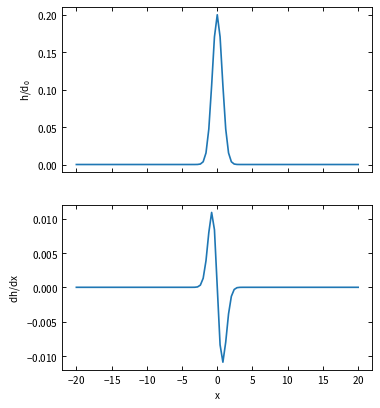

In [3]:
h = 0.2*d(0)*np.exp(-x**2)
dhdx = interp1d(x, central_diff_gradient(h, x), **interp_opts)
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(5, 6))
ax[0].plot(x, h/d(0))
ax[1].plot(x, dhdx(x))

ax[0].set(ylabel='$h/d_0$');
ax[1].set(xlabel='x', ylabel='$dh/dx$');

In [4]:
Image(url= "notation.png", width=500, height=500)

In [5]:
def integrate_characteristics(x, t, u, d, x0_chars):
    """Find u(x, t) and d(x, t) using method of characteristics
    
    Inputs
    ------
    x: 1d array
    t: 1d array
    u: interp1d object
        Starting velocity
    d: interp1d object
        Starting depth
    x0_chars: 1d array
        Points along x dimension in which to record characteristics

    Returns
    -------
    U: 2d array (t, x)
    D: 2d array (t, x)
    x0_chars: 2d array (t, x_chars)
    
   
    Summary of method
    -----
    Integrate forward in time using method close to implicit euler method.
    Assume we are integrating from t. Then for every x3(t + delta_t),
    find the values of x1 and x2 by using values of u and d at x3(t).
    
    With x1 and x2 known, solve the equations dξ/dt = -g dh/dx and 
    dη/dt = -g dh/dx where ξ = u + 2c and η = u - 2c
    """
    g = 9.81

    # Preallocate output
    nx, nt = len(x), len(t)
    t = t[1:]
    delta_t = np.diff(t).mean()
    U = np.empty((nt, nx))
    D = np.empty((nt, nx))
    
    neg_chars = np.empty((nt, len(x0_chars)))
    neg_chars[0, :] = x0_chars

    # First rows are starting values
    U[0, :] = u(x)
    D[0, :] = d(x)

    for j, t_i in enumerate(t, start=1):
        for k, x3 in enumerate(x):
            x1 = x3 - (u(x3) + np.sqrt(g*d(x3)))*delta_t
            x2 = x3 - (u(x3) - np.sqrt(g*d(x3)))*delta_t
            
            xi = u(x1) + 2*np.sqrt(g*d(x1))
            eta = u(x2) - 2*np.sqrt(g*d(x2))
            
            U[j, k] = (-g*(dhdx(x1) + dhdx(x2))*delta_t + xi + eta)/2
            root_gd = ((xi - eta) - g*(dhdx(x1) - dhdx(x2)))/4
            D[j, k] = root_gd**2/g
        
        # Update d and u
        d = interp1d(x, D[j, :], fill_value='extrapolate')
        u = interp1d(x, U[j, :], fill_value='extrapolate')
        
        # Track characteristics
        tmp_x = neg_chars[j - 1, :]
        neg_chars[j, :] = (u(tmp_x) - np.sqrt(g*d(tmp_x)))*delta_t + tmp_x
    
    return U, D, neg_chars

### Visualisations

In [6]:
def plot_surfaces(D, t):
    fig, ax = plt.subplots()
    ax.plot(x, (D.T + t/10)[:, ::3], 'k')
    ax.set(xlabel='x', ylabel='time/10')

def plot_characteristics(neg_chars, t):
    fig, ax = plt.subplots()
    ax.plot(neg_chars, t, 'k');
    ax.set(xlabel='x', ylabel='time');

### Fr$_0$ = 0.8

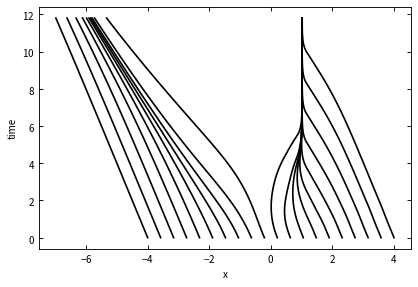

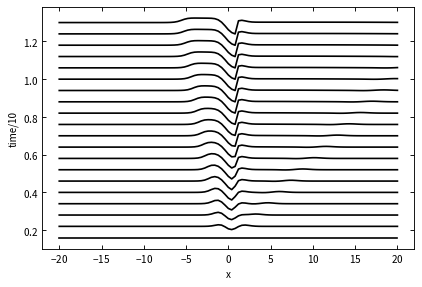

In [7]:
u, d = initial_vals(Fr=0.8)
U, D, neg_chars = integrate_characteristics(x, t, u, d, x0_chars)
plot_characteristics(neg_chars, t)
plot_surfaces(D, t)

Upstream of the obstacle at 0, the negative characteristics slowly converge to the same point representing the upstream jump.

Downstream of the obstacle, the initial drop in surface height over the obstacle causes the flow to become critical at the crest of the obstacle. Consequently, a hydraulic jump forms behind the obstacle. This occurs at approximately x = 1 where the characterisitics all converge.

### Fr$_0$ = 1.2

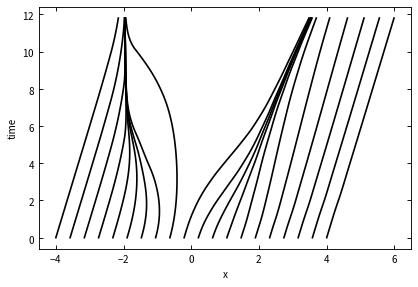

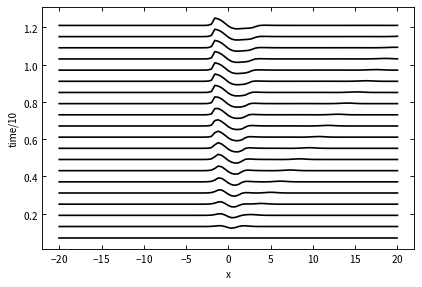

In [8]:
u, d = initial_vals(Fr=1.2)
U, D, neg_chars = integrate_characteristics(x, t, u, d, x0_chars)
plot_characteristics(neg_chars, t)
plot_surfaces(D, t)

Both the up and downstream waves are initial advected downstream as depressions in surface height. However, the increased thickness of the water column due to the steady part over the obstacle increases the local wave speed over the obstacle. Waves near the obstacle can therefore propogate upstream, but only so far. Away from the obstacle the thickness decreases, and so does the wave speed. All upstream propagating waves therefore converge at this point creating the upstream hydraulic jump.

# Same experiments with MITgcm
Using a two-layer reduced gravity model to replicate a free-surface

The same parameters (h/d0 = 0.2, Fr=0.8, 1.2) were used, but with oceanic scales.

Input files were generated with `./gendata.py`

In [9]:
import numpy.ma as ma
from xmitgcm import open_mdsdataset
from MyMITgcmUtils import get_grid
from MyFunctions import get_contour

In [10]:
def plot_free_surface(run):
    """Plot depth of interface
    
    Input
    -----
    run: str
        Name of model run. 'sub', 'super', etc. See runs directory
    """
    runs_dir = ('/home/hugke729/mitgcm/stratified_flow_directed_study/' + 
                'non_linear_1d_flow_proj2/runs/')
    run_dir = runs_dir + run + '/'

    ds = open_mdsdataset(run_dir, prefix=['T']).isel(j=0)
    g = get_grid(run_dir);
    
    fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))
    offset = 10
    for i, time in enumerate(np.array(ds.time)[::3]):
        contour = get_contour(g.xc, g.zc, np.array(ds['T'].isel(time=i)), 2.5)
        ax[1].plot(g.xc_km, -contour + offset, 'k')
        offset += ma.ptp(contour)/2
    
    # Plot last contour with depth
    ax[0].plot(g.xc_km, -contour, 'k')
    ax[0].fill_between(g.xc_km, -g.depth, -1010, color='grey')
    ax[0].set(xlabel='Distance (km)', ylabel='Depth')
    ax[1].set(xlabel='Distance (km)', yticks=[], ylabel='Time increasing')
    ax[0].set(title='State after 24 hours')
    ax[1].set(title='Evolution with time')
    fig.suptitle(run, fontsize=16)

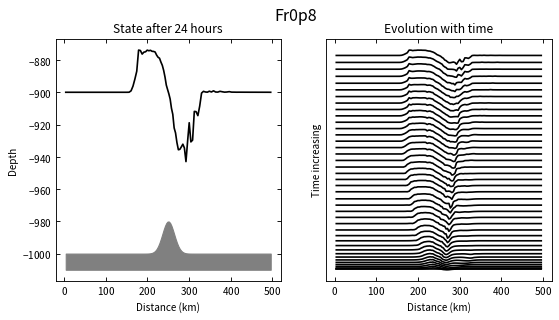

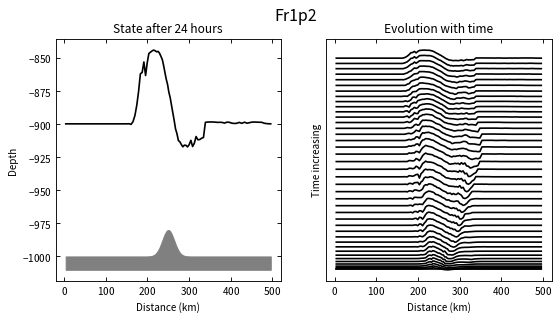

In [11]:
plot_free_surface('Fr0p8')
plot_free_surface('Fr1p2')

These numerical simulations have vastly different scales compared to the method of characteristics.
However, because they have the same non-dimensional parameters (h0, Fr), the
results are essentially the same, as evident by comparison of the surface evolution with time.

# Jump speed

\* __I'm not sure if my calculations are wrong or not. I'm getting factor-of-two  
differences in values that I would expect to be the same.

Equation 2.3.13 of Baines (1995) gives the jump speed of a hydraulic jump as
$$ c_j^2 = \frac{g d_d}{2}\left(1 + \frac{d_d}{d_u} \right)$$

where $g = g/1000 = 0.0098$ m/s$^2$

In both simulations, jumps form both up and downstream of the obstacle.  
All jumps are stationary by the end of the simulation.  
Plots above are used for values of $d_u$ and $d_d$

For the Fr = 0.8 case:  
  - Upstream:  
    - $d_u = 100$ m
    - $d_d = 124$ m
    - $c_j = 1.16$ m/s
    - However, the current speed just upstream of this jump,  
      which should be equal and opposite to the jump speed,  
      is 0.8 m/s
  - Downstream:
    - $d_u = 65$ m
    - $d_d = 100$ m
    - $c_j = 1.12$ m/s
    - The current speed just upstream of this jump is 1.13 m/s

For the Fr = 1.2 case:  
  - Upstream:
    - $d_u = 100$ m
    - $d_d = 155$ m
    - $c_j = 1.39$ m/s
    - However, the current speed just upstream of this jump is 1.18 m/s
  - Downstream
    - $d_u = 80$ m
    - $d_d = 100$ m
    - $c_j = 1.05$ m/s
    - However, the current speed just upstream of this jump is 1.40 m/s

Of the four jumps that I calculated the jump speed for, only one is  
equal and opposite to the speed of the oncoming current. This could  
easily just be by chance (right for the wrong reasons).

Further, there is no clear relationship between predicted jump speed
and speed of current just upstream.

Alternatively, the discrepancies in the results may arise from the  
velocity not being constant with depth, an assumption used in getting  
to Equation 2.3.13

# Energy loss in jump

Equation 2.3.12 of Baines (1995) gives the rate of dissipation of energy in the jump as

$$ \frac{\mathrm{d} E_j}{\mathrm{d} t} = \frac{\rho_0 g Q}{4} \frac{(d_d - d_u)^3}{d_d d_u}$$

where $Q$ is the volume flux $u_u d_u = u_d d_d$ and  

Values for $d_u$ and $d_d$ are given in the cell above

I will compare these to values output from the KL10 package.  

$$\epsilon_\mathrm{kl10} = \int_A \epsilon \mathrm{d}A$$

where $A$ is the area in the $x$-$z$ plane containing the jump.  


For the Fr = 0.8 case:
  - Upstream:  
    - Q = 0.79 m/s × 100 m = 79 m$^2$/s  
    - Dissipation/\rho = (0.0098 × 79)/4 × (124 - 100)$^3$/(124 × 100) = 0.22 m$^4$/s$^3$
    - $\epsilon_\mathrm{kl10}$ = 0.20 m$^4$/s$^3$
  - Downstream:  
    - Q is as above  
    - Dissipation/\rho = (0.0098 × 79)/4 × (100 - 65)$^3$/(100 × 65) = 1.3 m$^4$/s$^3$
    - $\epsilon_\mathrm{kl10}$ = 1.0 m$^4$/s$^3$

For the Fr = 1.2 case:
  - Upstream:  
    - Q = 1.18 m/s × 100 m = 118 m$^2$/s  
    - Dissipation/\rho = (0.0098 × 118)/4 × (155 - 100)$^3$/(155 × 100) = 2.1 m$^4$/s$^3$
    - $\epsilon_\mathrm{kl10}$ = 5.0 m$^4$/s$^3$
  - Downstream:  
    - Q is as above  
    - Dissipation/\rho = (0.0098 × 118)/4 × (100 - 80)$^3$/(100 × 80) = 0.20 m$^4$/s$^3$
    - $\epsilon_\mathrm{kl10}$ = 1.3 m$^4$/s$^3$
 
The Fr = 0.8 case has larger dissipation in the downstream jump.  
The opposite is the case for the Fr = 1.2 case

The comparison between the analytical estimate and the KL10 dissipation estimate  
is reasonable in the Fr = 0.8 case, but KL10 values are 3--6 times larger  
in the Fr = 1.2 case.

Larger values for the KL10 estimate would be expected as they will include some  
shear-driven dissipation not accounted for in the analytical estimates.

# Flows under different regimes

Recreate flows in the regimes in Figure 2.11 of Baines (1995)

I used the following parameters

| Name                   | Short Name           | h_0 | Fr  |
|------------------------|----------------------|-----|-----|
| Subcritical            | sub                  | 0.2 | 0.2 |
| Supercritical          | super                | 0.2 | 2.0 |
| Complete Blocking      | complete_block       | 2.0 | 0.2 |
| Partial Block with Lee | partial_block_w_lee  | 1.0 | 0.2 |
| Partial Block, no Lee  | partial_block_no_lee | 1.0 | 1.0 |

Input files were generated with ./gendata.py

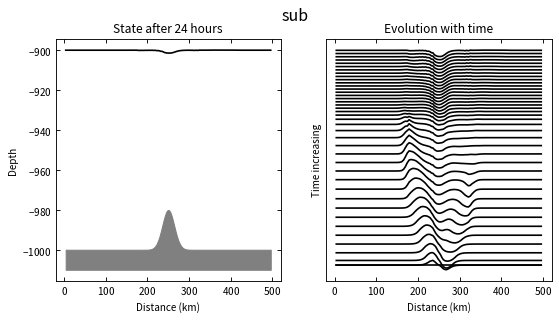

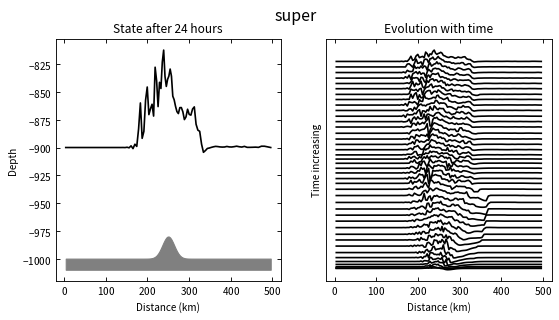

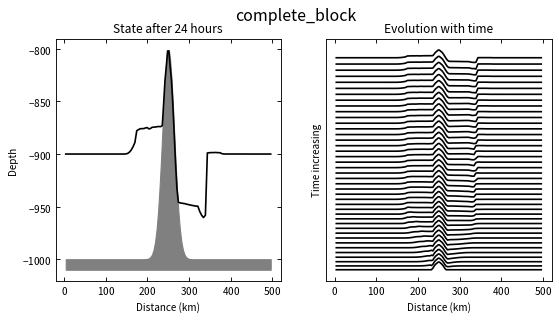

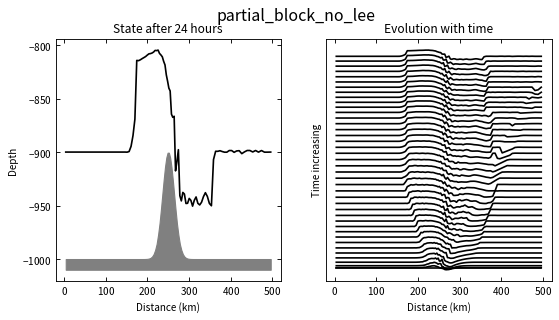

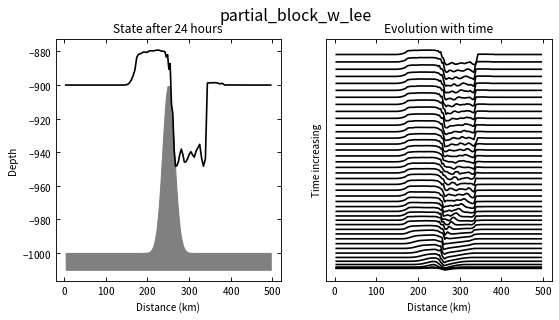

In [14]:
for regime in ['sub', 'super', 'complete_block', 'partial_block_no_lee',
               'partial_block_w_lee']:
    plot_free_surface(regime)

Notes
-----
* The Partial blocking case with and without lee look similar at 24 hours, but the no lee situation has not reached steady state. As evident in the evolution with time panel, the shock is still propogating away in the no-lee situation.

* The supercritical run didn't work well as a number of other processes occurred beyond one-layer flow, e.g., shear-driven instabilities. The large-scale behaviour is still visible in the form of a raised surface over the bump.